In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from math import sqrt
import numpy as np
from scipy.stats import pearsonr
import os
import json
import joblib

In [6]:

# Execute the function with the defined parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
with open('synop_codes.json', "r") as fp:
    synop_codes = json.load(fp)
model_path  = "model/"
fso_models_path = model_path  + "fso_models.pkl"
rfl_models_path = model_path  +"rfl_models.pkl"
train_data_path = model_path  +"train_data.csv"
test_data_path = model_path  +"test_data.csv"
best_params_fso_path = model_path  +"best_params_fso.json"
best_params_rfl_path = model_path  + "best_params_rfl.json"
rmse_results_path = model_path  + "rmse_results.csv"
r2_results_path = model_path  + "r2_results.csv"

In [7]:
if (os.path.isfile(fso_models_path) and
    os.path.isfile(rfl_models_path) and
    os.path.isfile(train_data_path) and
    os.path.isfile(test_data_path) and
    os.path.isfile(best_params_fso_path) and
    os.path.isfile(best_params_rfl_path) and
    os.path.isfile(rmse_results_path) and
    os.path.isfile(r2_results_path)):
    
    print("Loading previously saved files...")
    # -- Load the objects --
    fso_models = joblib.load(fso_models_path)
    rfl_models = joblib.load(rfl_models_path)
    
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    
    with open(best_params_fso_path, "r") as fp:
        best_params_fso = json.load(fp)
    with open(best_params_rfl_path, "r") as fp:
        best_params_rfl = json.load(fp)

    rfl_table_final = pd.read_csv('rfl_table_final.csv')
    fso_table_final=  pd.read_csv('fso_table_final.csv')    

    rmse_results = pd.read_csv(rmse_results_path)
    r2_results = pd.read_csv(r2_results_path)
    
    print("Successfully loaded saved models and data.")

else:
    print("Saved files not found.")

Loading previously saved files...
Successfully loaded saved models and data.


In [8]:
R2_TRESHOLD = 0.01
RMSE_THRESHOLD = 0.02

def find_threshold(data_table):
    """
    Given a table containing the columns ['RMSE', 'R2'],
    iterates row-by-row and finds the index where:
       - The relative decrease in R² > R2_TRESHOLD
       - AND the relative increase in RMSE > RMSE_THRESHOLD
    Returns that row index or the last index if not found.
    """
    for i in range(len(data_table) - 1):
        r2_current = data_table['R2'].iloc[i]
        r2_next    = data_table['R2'].iloc[i + 1]
        rmse_curr  = data_table['RMSE'].iloc[i]
        rmse_next  = data_table['RMSE'].iloc[i + 1]

        r2_decrease = (r2_current - r2_next) / r2_current
        rmse_increase = (rmse_next - rmse_curr) / rmse_curr

        if (r2_decrease > R2_TRESHOLD) and (rmse_increase > RMSE_THRESHOLD):
            return i
    return len(data_table) - 1

In [9]:
def extract_selected_features(table):
    """
    Finds the threshold index for selecting the most important features.
    Extract features following the threshold index.
    """ 
    feature_index = find_threshold(table)
    # manuaually choose best features RFL specfic model (dust storm) based on feature selection performance plot
    if feature_index>=23:
        feature_index = 14
        
    selected_features = table['Removed_Feature'][feature_index:]

    return selected_features

In [10]:
# Get unique selected features for each target model after thresholding
fso_important_features = fso_table_final.groupby('SYNOPCode')[['RMSE','R2','Removed_Feature']].apply(lambda x: extract_selected_features(x))
rfl_important_features = rfl_table_final.groupby('SYNOPCode')[['RMSE','R2','Removed_Feature']].apply(lambda x: extract_selected_features(x))


In [11]:
def perform_feature_selection_generic(df, target, param_random_state=42):
    """
    Iteratively remove the least important feature based on a RandomForestRegressor
    with OOB estimates, until all features are removed.

    Returns:
      feature_removal_log: a dataframe with columns [Removed_Feature, RMSE, R2]
      final_threshold_idx: the stopping index found by find_threshold(...)
    """
    # Start with all columns except the target
    remaining_features = [col for col in df.columns if col != target]

    # Container for results at each iteration
    results = []

    while len(remaining_features) > 0:
        # Train RF with OOB predictions
        rf = RandomForestRegressor(
            oob_score=True,
            random_state=param_random_state
        )
        rf.fit(df[remaining_features], df[target])

        oob_pred = rf.oob_prediction_
        rmse = sqrt(mean_squared_error(df[target], oob_pred))
        r2   = r2_score(df[target], oob_pred)

        # Identify least important feature
        importances = pd.Series(rf.feature_importances_, index=remaining_features)
        least_important = importances.idxmin()

        results.append({
            "Removed_Feature": least_important,
            "RMSE": rmse,
            "R2": r2
        })

        # Remove from our working set
        remaining_features.remove(least_important)

    # Build a DataFrame
    feature_removal_log = pd.DataFrame(results)
    # The last iteration leaves 0 features in the model, so the final row is with the final feature removed
    # You might want to keep the iteration that has N features. This is standard for "backward" style approach.

    # Find threshold
    final_threshold_idx = find_threshold(feature_removal_log)

    return feature_removal_log, final_threshold_idx

In [12]:
# -------------------------------------------------------
# 2) Method-2 (RFL → FSO) with Feature Selection & Re-tuning
#    for the GENERIC case
# -------------------------------------------------------
def method2_rfl_to_fso_generic(train_data, test_data,
                               rfl_features_generic,    # list of original features for RFL
                               rfl_model_generic,       # trained RFL (generic) model
                               param_grid,              # hyperparameter search space
                               random_state=42):
    """
    1) Use rfl_model_generic to predict RFL on the train set.
    2) Create new train set with X_fso_train['RFL_pred'] added.
    3) Perform feature selection on the new set of columns to predict FSO_Att.
    4) Re-run hyperparameter tuning with the final subset of features.
    5) Evaluate on test set: predict RFL, build final FSO feature set, get predictions, then compute correlation.
    Returns:
       final_correlation (float): Pearson correlation between RFL_pred and final FSO_pred on test
       best_model (sklearn model): the final trained FSO model with new subset
       final_features (list): the subset of features used in the final model
       selection_table (DataFrame): the iteration log from feature selection
    """
    # Initialize separate tables for FSO_Att and RFL_Att for each SYNOP code
    target_features = ['FSO_Att', 'RFL_Att']
    # 2.1) Predict RFL on the training set
    X_rfl_train = train_data[rfl_features_generic]
    rfl_train_pred = rfl_model_generic.predict(X_rfl_train)

    # 2.2) Build the augmented feature set for FSO
    fso_features = [col for col in train_data.columns if col not in target_features]
    X_fso_train_aug = train_data[fso_features].copy()
    X_fso_train_aug['RFL_pred'] = rfl_train_pred

    # The target
    y_fso_train = train_data['FSO_Att']

    # We want to perform feature selection on X_fso_train_aug, targeting y_fso_train
    # So let's combine them into a single DF for convenience:
    df_for_selection = X_fso_train_aug.copy()
    df_for_selection['FSO_Att'] = y_fso_train

    selection_table, threshold_idx = perform_feature_selection_generic(
        df_for_selection, target='FSO_Att', param_random_state=random_state
    )

    # Extract the final subset of features from the iteration log
    # 'Removed_Feature' is the feature removed at each iteration.
    # Suppose the log has N steps if we started with M features, the final row is after removing all M features.
    # We want the subset at "threshold_idx".
    # Option 1: build from the start, removing features up to threshold_idx
    removed_up_to_threshold = selection_table['Removed_Feature'].iloc[:threshold_idx+1].tolist()
    # The original features in df_for_selection:
    all_cols = [c for c in df_for_selection.columns if c != 'FSO_Att']
    # Subset is everything except the removed features up to that index
    final_features = [c for c in all_cols if c not in removed_up_to_threshold]

    # 2.3) Re-run hyperparameter tuning on the final feature set
    # Build X with final subset
    X_fso_train_final = X_fso_train_aug[final_features]

    rf_for_tuning = RandomForestRegressor(random_state=random_state)
    search = RandomizedSearchCV(
        estimator=rf_for_tuning,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        random_state=random_state,
        n_jobs=-1
    )
    search.fit(X_fso_train_final, y_fso_train)
    best_params = search.best_params_

    # Train the final FSO model with best_params
    best_model = RandomForestRegressor(**best_params, random_state=random_state)
    best_model.fit(X_fso_train_final, y_fso_train)

    # # 2.4) Evaluate on the test set
    # # Predict RFL on test
    # X_rfl_test = test_data[rfl_features_generic]
    # rfl_test_pred = rfl_model_generic.predict(X_rfl_test)

    # X_fso_test_aug = test_data[fso_features].copy()
    # X_fso_test_aug['RFL_pred'] = rfl_test_pred

    # # Keep only the final features
    # X_fso_test_final = X_fso_test_aug[final_features]

    # # Predict FSO
    # fso_test_pred = best_model.predict(X_fso_test_final)

    # # Compute correlation
    # corr, _ = pearsonr(rfl_test_pred, fso_test_pred)

    return best_model, final_features, selection_table, threshold_idx

In [14]:
def plot_feature_selection(
    rfl_table,
    fso_table,
    rfl_threshold=None,
    fso_threshold=None,
    title="Feature Selection Performance"
):
    """
    Generates side-by-side plots of RMSE and R² for RFL_Att and FSO_Att
    as a function of removed features in feature selection.
    
    Parameters
    ----------
    rfl_table : pd.DataFrame
        DataFrame containing columns:
            - 'Removed_Feature'
            - 'RMSE'
            - 'R2'
        for the RFL_Att feature selection iteration.
        
    fso_table : pd.DataFrame
        DataFrame containing columns:
            - 'Removed_Feature'
            - 'RMSE'
            - 'R2'
        for the FSO_Att feature selection iteration.
        
    rfl_threshold : int, optional
        The index from feature selection to mark on RFL plot 
        (e.g., from find_threshold(...)). If None, no vertical line is drawn.
        
    fso_threshold : int, optional
        The index from feature selection to mark on FSO plot.
        If None, no vertical line is drawn.
        
    title : str, optional
        A main title for the figure. Defaults to "Feature Selection Performance".
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    axes : np.ndarray of matplotlib.axes.Axes
        The array of subplot axes ([ax_rfl, ax_fso]).
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    # --------------------------
    # Left Plot: RFL_Att
    # --------------------------
    axes[0].plot(
        rfl_table['Removed_Feature'],
        rfl_table['RMSE'],
        label="RMSE (dB)",
        color="blue"
    )
    axes[0].set_ylabel("RMSE (dB)", color="blue")
    axes[0].tick_params(axis="y", labelcolor="blue")

    ax_r4 = axes[0].twinx()
    ax_r4.plot(
        rfl_table['Removed_Feature'],
        rfl_table['R2'],
        label="R²",
        color="red"
    )
    ax_r4.set_ylabel("R²", color="red")
    ax_r4.tick_params(axis="y", labelcolor="red")

    # Mark threshold if given
    if rfl_threshold is not None and 0 <= rfl_threshold < len(rfl_table):
        axes[0].axvline(
            x=rfl_threshold,
            color="green",
            linestyle="--",
            label="1% R² Threshold"
        )

    axes[0].set_title("(a) RFL_Att")
    axes[0].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)

    # --------------------------
    # Right Plot: FSO_Att
    # --------------------------
    axes[1].plot(
        fso_table['Removed_Feature'],
        fso_table['RMSE'],
        label="RMSE (dB)",
        color="blue"
    )
    axes[1].set_ylabel("RMSE (dB)", color="blue")
    axes[1].tick_params(axis="y", labelcolor="blue")

    ax_f2 = axes[1].twinx()
    ax_f2.plot(
        fso_table['Removed_Feature'],
        fso_table['R2'],
        label="R²",
        color="red"
    )
    ax_f2.set_ylabel("R²", color="red")
    ax_f2.tick_params(axis="y", labelcolor="red")

    # Mark threshold if given
    if fso_threshold is not None and 0 <= fso_threshold < len(fso_table):
        axes[1].axvline(
            x=fso_threshold,
            color="green",
            linestyle="--",
            label="1% R² Threshold"
        )

    axes[1].set_title("(b) FSO_Att")
    axes[1].set_xticklabels(fso_table['Removed_Feature'], rotation=90)

    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [15]:
# -------------------------------------------------------
# 2) Method-3 (FSO → RFL) with Feature Selection & Re-tuning
#    for the GENERIC case
# -------------------------------------------------------
def method3_fso_to_rfl_generic(train_data, test_data,
                               fso_features_generic,    # list of original features for FSO
                               fso_model_generic,       # trained FSO (generic) model
                               param_grid,              # hyperparameter search space
                               random_state=42):
    """
    1) Use fso_model_generic to predict RFL on the train set.
    2) Create new train set with X_rfl_train['FSO_pred'] added.
    3) Perform feature selection on the new set of columns to predict RFL_Att.
    4) Re-run hyperparameter tuning with the final subset of features.
    5) Evaluate on test set: predict RFL, build final RFL feature set, get predictions, then compute correlation.
    Returns:
       final_correlation (float): Pearson correlation between FSO_pred and final RFL_pred on test
       best_model (sklearn model): the final trained RFL model with new subset
       final_features (list): the subset of features used in the final model
       selection_table (DataFrame): the iteration log from feature selection
    """
    # Initialize separate tables for FSO_Att and RFL_Att for each SYNOP code
    target_features = ['FSO_Att', 'RFL_Att']
    # 2.1) Predict RFL on the training set
    X_fso_train = train_data[fso_features_generic]
    fso_train_pred = fso_model_generic.predict(X_fso_train)

    # 2.2) Build the augmented feature set for FSO
    rfl_features = [col for col in train_data.columns if col not in target_features]
    X_rfl_train_aug = train_data[rfl_features].copy()
    X_rfl_train_aug['FSO_pred'] = fso_train_pred

    # The target
    y_rfl_train = train_data['RFL_Att']

    # We want to perform feature selection on X_rfl_train_aug, targeting y_rfl_train
    # So let's combine them into a single DF for convenience:
    df_for_selection = X_rfl_train_aug.copy()
    df_for_selection['RFL_Att'] = y_rfl_train

    selection_table, threshold_idx = perform_feature_selection_generic(
        df_for_selection, target='RFL_Att', param_random_state=random_state
    )

    # Extract the final subset of features from the iteration log
    # 'Removed_Feature' is the feature removed at each iteration.
    # Suppose the log has N steps if we started with M features, the final row is after removing all M features.
    # We want the subset at "threshold_idx".
    # Option 1: build from the start, removing features up to threshold_idx
    removed_up_to_threshold = selection_table['Removed_Feature'].iloc[:threshold_idx+1].tolist()
    # The original features in df_for_selection:
    all_cols = [c for c in df_for_selection.columns if c != 'RFL_Att']
    # Subset is everything except the removed features up to that index
    final_features = [c for c in all_cols if c not in removed_up_to_threshold]

    # 2.3) Re-run hyperparameter tuning on the final feature set
    # Build X with final subset
    X_rfl_train_final = X_rfl_train_aug[final_features]

    rf_for_tuning = RandomForestRegressor(random_state=random_state)
    search = RandomizedSearchCV(
        estimator=rf_for_tuning,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        random_state=random_state,
        n_jobs=-1
    )
    search.fit(X_rfl_train_final, y_rfl_train)
    best_params = search.best_params_

    # Train the final FSO model with best_params
    best_model = RandomForestRegressor(**best_params, random_state=random_state)
    best_model.fit(X_rfl_train_final, y_rfl_train)

    # # 2.4) Evaluate on the test set
    # # Predict RFL on test
    # X_fso_test = test_data[fso_features_generic]
    # fso_test_pred = fso_model_generic.predict(X_fso_test)

    # X_rfl_test_aug = test_data[rfl_features].copy()
    # X_rfl_test_aug['FSO_pred'] = fso_test_pred

    # # Keep only the final features
    # X_rfl_test_final = X_rfl_test_aug[final_features]

    # # Predict FSO
    # rfl_test_pred = best_model.predict(X_rfl_test_final)

    # # Compute correlation
    # corr, _ = pearsonr(fso_test_pred, rfl_test_pred)

    return best_model, final_features, selection_table, threshold_idx

In [13]:
fso_model_method2, selected_feats_method2, fso_table_method2, fso_threshold = method2_rfl_to_fso_generic(
    train_data=train_data,
    test_data=test_data,
    rfl_features_generic=rfl_important_features['generic'],
    rfl_model_generic=rfl_models['generic'],  # your pre-trained RFL generic model
    param_grid=param_grid,
    random_state=42
)

print("Final selected features:", selected_feats_method2)
print("Hyperparameter-tuned FSO model:", fso_model_method2)

Final selected features: ['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMin', 'Temperature', 'TemperatureMax', 'TemperatureMin', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'RFL_pred']
Hyperparameter-tuned FSO model: RandomForestRegressor(min_samples_leaf=2, min_samples_split=10, n_estimators=50,
                      random_state=42)
Feature-selection iteration log:
           Removed_Feature      RMSE        R2
0               Frequency  0.835585  0.954287
1           RainIntensity  0.834545  0.954401
2        RainIntensityMin  0.833208  0.954547
3               SYNOPCode  0.834395  0.954417
4        RainIntensityMax  0.835750  0.954269
5           WindDirection  0.837785  0.954046
6               WindSpeed  0.827246  0.955195
7     AbsoluteHumidityMin  0.828160  0.955096
8     AbsoluteHumidityMax  0.820009  0.955975
9            WindSpeedMin  0.813215  0.956702
10           WindSpeedMax  0.826146  0.955314
11  TemperatureDifference  0.839519  0.953855
12         Par

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_69608/3404222603.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_69608/3404222603.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(fso_table['Removed_Feature'], rotation=90)


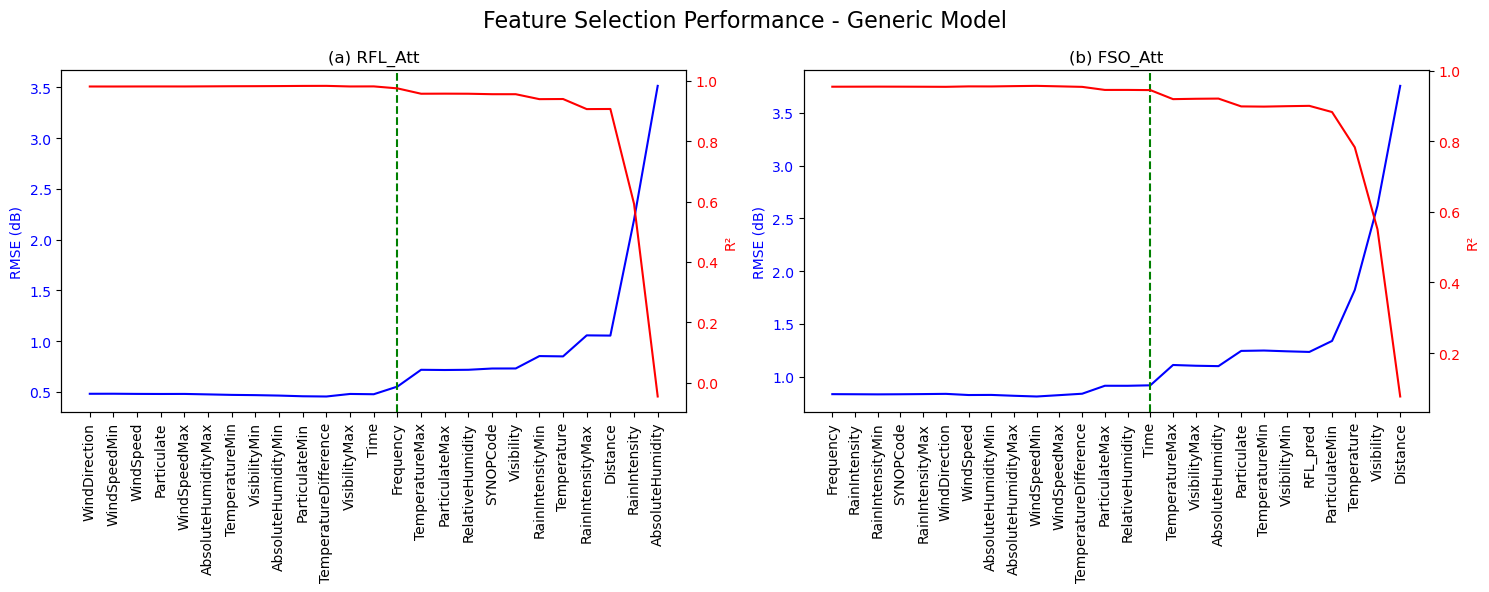

In [15]:
# Extract feature selection table for generic model and obtain selected feature threshold index 
rfl_table = rfl_table_final[rfl_table_final['SYNOPCode']=='generic']
rfl_threshold = find_threshold(rfl_table)
fig, axes = plot_feature_selection(
    rfl_table=rfl_table,
    fso_table=fso_table_method2,
    rfl_threshold=rfl_threshold,
    fso_threshold=fso_threshold,
    title="Feature Selection Performance - Method 2 Generic Model"
)

In [18]:
rfl_model_method3, selected_feats_method3, rfl_table_method3, rfl_threshold = method3_fso_to_rfl_generic(
    train_data=train_data,
    test_data=test_data,
    fso_features_generic=fso_important_features['generic'],
    fso_model_generic=fso_models['generic'],  # your pre-trained RFL generic model
    param_grid=param_grid,
    random_state=42
)

print("Final selected features:", selected_feats_method3)
print("Hyperparameter-tuned FSO model:", rfl_model_method3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# Extract feature selection table for generic model and obtain selected feature threshold index 
fso_table = fso_table_final[fso_table_final['SYNOPCode']=='generic']
fso_threshold = find_threshold(rfl_table)
fig, axes = plot_feature_selection(
    rfl_table=rfl_table_method3,
    fso_table=fso_table,
    rfl_threshold=rfl_threshold,
    fso_threshold=fso_threshold,
    title="Feature Selection Performance - Method 3 Generic Model"
)

Running method2_rfl_to_fso_generic and saving results...
Final selected features (Method 2): ['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMin', 'Temperature', 'TemperatureMax', 'TemperatureMin', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'RFL_pred']
Hyperparameter-tuned FSO model (Method 2): RandomForestRegressor(min_samples_leaf=2, min_samples_split=10, n_estimators=50,
                      random_state=42)


/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_40990/3404222603.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_40990/3404222603.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(fso_table['Removed_Feature'], rotation=90)


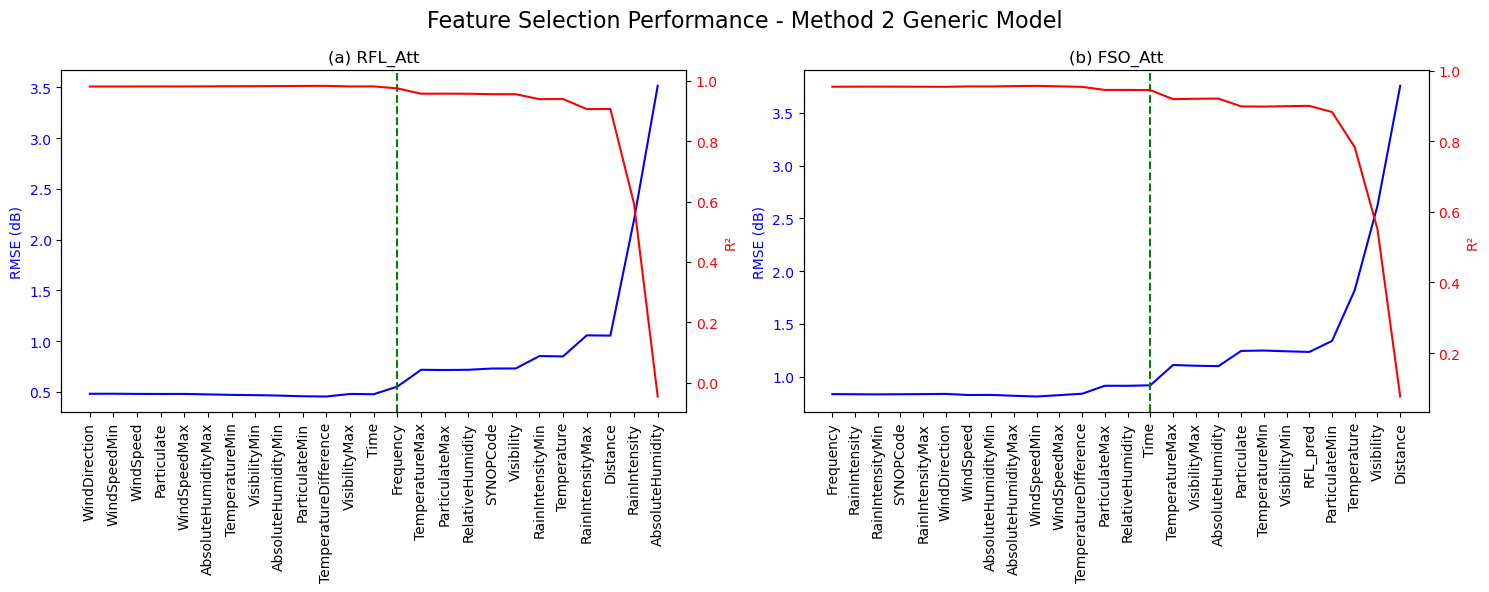

Running method3_fso_to_rfl_generic and saving results...
Final selected features (Method 3): ['AbsoluteHumidity', 'Distance', 'ParticulateMax', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureMax', 'TemperatureMin', 'Visibility', 'FSO_pred']
Hyperparameter-tuned FSO model (Method 3): RandomForestRegressor(min_samples_leaf=2, min_samples_split=10, n_estimators=50,
                      random_state=42)


/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_40990/3404222603.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_40990/3404222603.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(fso_table['Removed_Feature'], rotation=90)


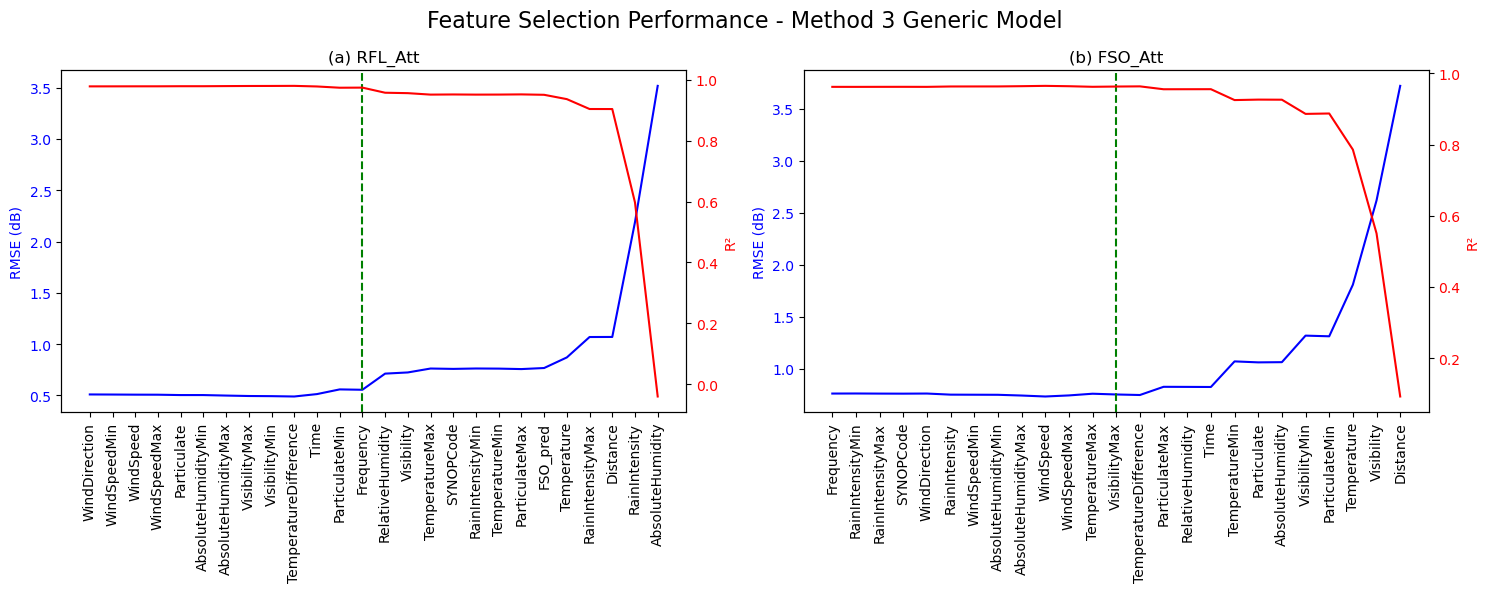

In [16]:
import os
import pickle

# Define file paths
method2_results_path = model_path+ "method2_results.pkl"
method3_results_path = model_path+ "method3_results.pkl"

# Function to load or run and save results
def load_or_run_method(file_path, method_func, **kwargs):
    if os.path.exists(file_path):
        print(f"Loading results from {file_path}...")
        with open(file_path, "rb") as f:
            results = pickle.load(f)
    else:
        print(f"Running {method_func.__name__} and saving results...")
        results = method_func(**kwargs)
        with open(file_path, "wb") as f:
            pickle.dump(results, f)
    return results

# Run or load Method 2
fso_model_method2, selected_feats_method2, fso_table_method2, fso_threshold = load_or_run_method(
    method2_results_path,
    method2_rfl_to_fso_generic,
    train_data=train_data,
    test_data=test_data,
    rfl_features_generic=rfl_important_features['generic'],
    rfl_model_generic=rfl_models['generic'],
    param_grid=param_grid,
    random_state=42
)

print("Final selected features (Method 2):", selected_feats_method2)
print("Hyperparameter-tuned FSO model (Method 2):", fso_model_method2)

# Extract feature selection table and obtain threshold index
rfl_table = rfl_table_final[rfl_table_final['SYNOPCode'] == 'generic']
rfl_threshold = find_threshold(rfl_table)

# Plot feature selection performance for Method 2
fig, axes = plot_feature_selection(
    rfl_table=rfl_table,
    fso_table=fso_table_method2,
    rfl_threshold=rfl_threshold,
    fso_threshold=fso_threshold,
    title="Feature Selection Performance - Method 2 Generic Model"
)

# Run or load Method 3
rfl_model_method3, selected_feats_method3, rfl_table_method3, rfl_threshold = load_or_run_method(
    method3_results_path,
    method3_fso_to_rfl_generic,
    train_data=train_data,
    test_data=test_data,
    fso_features_generic=fso_important_features['generic'],
    fso_model_generic=fso_models['generic'],
    param_grid=param_grid,
    random_state=42
)

print("Final selected features (Method 3):", selected_feats_method3)
print("Hyperparameter-tuned FSO model (Method 3):", rfl_model_method3)

# Extract feature selection table and obtain threshold index
fso_table = fso_table_final[fso_table_final['SYNOPCode'] == 'generic']
fso_threshold = find_threshold(rfl_table_method3)

# Plot feature selection performance for Method 3
fig, axes = plot_feature_selection(
    rfl_table=rfl_table_method3,
    fso_table=fso_table,
    rfl_threshold=rfl_threshold,
    fso_threshold=fso_threshold,
    title="Feature Selection Performance - Method 3 Generic Model"
)


In [69]:
import numpy as np

def entropy(p):
    """
    Compute the entropy of a probability distribution.

    Parameters:
    -----------
    p : array-like
        Probability distribution.

    Returns:
    --------
    float
        Entropy value.
    """
    p_nonzero = p[p > 0]  # Consider only positive probabilities
    return -np.sum(p_nonzero * np.log2(p_nonzero))

def joint_entropy_and_heatmap(X, Y, bin_width):
    """
    Estimate the entropy H(X), H(Y), joint entropy H(X, Y), and mutual information I(X; Y)
    of two continuous random variables X and Y. Also, return the 2D histogram.

    Parameters:
    -----------
    X : array-like
        Samples of the first random variable.
    Y : array-like
        Samples of the second random variable.
    bin_width : float
        Width of each bin for both X and Y.

    Returns:
    --------
    H_X : float
        Estimated entropy of X.
    H_Y : float
        Estimated entropy of Y.
    H_XY : float
        Estimated joint entropy of (X, Y).
    I_XY : float
        Estimated mutual information between X and Y.
    I_XY_norm : float
        Normalized mutual information I(X;Y) / H(X,Y).
    hist_2d : ndarray
        Computed 2D histogram.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Determine range for each variable
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    
    # Create bin edges for X and Y
    x_edges = np.arange(x_min, x_max + bin_width, bin_width)
    y_edges = np.arange(y_min, y_max + bin_width, bin_width)
    
    # Compute 2D histogram
    hist_2d, _, _ = np.histogram2d(X, Y, bins=[x_edges, y_edges])
    
    # Convert histogram to joint probability distribution
    p_xy = hist_2d / np.sum(hist_2d)

    # Compute marginal distributions
    p_x = np.sum(p_xy, axis=1)  # Sum along Y-axis to get p(X)
    p_y = np.sum(p_xy, axis=0)  # Sum along X-axis to get p(Y)
    
    # Compute entropies
    H_X = entropy(p_x)
    H_Y = entropy(p_y)
    H_XY = entropy(p_xy)

    # Compute mutual information
    I_XY = H_X + H_Y - H_XY

    # Compute normalized mutual information
    I_XY_norm = I_XY / H_XY if H_XY > 0 else 0  # Avoid division by zero
    
    return  H_XY, I_XY_norm, hist_2d.T  # Transposed for correct visualization


In [70]:
# Initialize dictionaries
correlation_results = {method: {} for method in ["measured", "method1_Generic", "method2_Generic", "method3_Generic"]}
norm_mutual_inf_results = {method: {} for method in correlation_results.keys()}
heatmaps = {method: {} for method in correlation_results.keys()}

bin_width = 1

# Define SYNOP code descriptions and filter the dataset by each code
rmse_results_dict = {'method2_Generic':[], 'method3_Generic':[]}
r2_results_dict={'method2_Generic':[], 'method3_Generic':[]}


correlation_results = {
    "measured": {},
    "method1_Generic": {},
    "method2_Generic": {},
    "method3_Generic": {}
}

norm_mutual_inf_results = {
    "measured": {},
    "method1_Generic": {},
    "method2_Generic": {},
    "method3_Generic": {}
}

bin_width = 1
target_features = ['FSO_Att', 'RFL_Att']
features = [col for col in test_data.columns if col not in target_features]

for code in synop_codes.keys():
    test_subset = test_data[test_data['SYNOPCode'] == int(code)]
    if len(test_subset) < 10:
        continue
    
    #------------------------------------------------
    # Measured correlation + entropy
    #------------------------------------------------
    x_measured = test_subset['RFL_Att'].values
    y_measured = test_subset['FSO_Att'].values
    
    corr_measured, _ = pearsonr(x_measured, y_measured)
    H_measured,I_XY_norm_measured, heatmap_measured = joint_entropy_and_heatmap(x_measured, y_measured, bin_width=bin_width)
    
    correlation_results["measured"][code] = corr_measured
    norm_mutual_inf_results["measured"][code] = I_XY_norm_measured
    heatmaps["measured"][code]  = heatmap_measured
    
    #------------------------------------------------
    # method1_Generic
    #------------------------------------------------
    rfl_test_pred_method1 = rfl_models['generic'].predict(test_subset[rfl_important_features['generic']])

    fso_test_pred_method1 = fso_models['generic'].predict(test_subset[fso_important_features['generic']])

    # Correlation + entropy for predicted
    corr_method1, _ = pearsonr(rfl_test_pred_method1, fso_test_pred_method1)
    H_method1,I_XY_norm_method1, heatmap_method1 = joint_entropy_and_heatmap(rfl_test_pred_method1, fso_test_pred_method1, bin_width=bin_width)
    
    # Correlation + entropy for predicted
    correlation_results["method1_Generic"][code] = corr_method1
    norm_mutual_inf_results["method1_Generic"][code] = I_XY_norm_method1
    heatmaps["method1_Generic"][code]  = heatmap_method1

    #------------------------------------------------
    # method2_Generic model evaluation
    #------------------------------------------------   
    X_fso_test_aug_method2 = test_subset[features].copy()
    X_fso_test_aug_method2['RFL_pred'] = rfl_test_pred_method1

    # Keep only the final features
    X_fso_test_final = X_fso_test_aug_method2[selected_feats_method2]

    # Predict FSO
    fso_test_pred_method2 = fso_model_method2.predict(X_fso_test_final)

    # Correlation + entropy for predicted
    corr_method2, _ = pearsonr(rfl_test_pred_method1, fso_test_pred_method2)
    H_method2,I_XY_norm_method2, heatmap_method2 = joint_entropy_and_heatmap(rfl_test_pred_method1, fso_test_pred_method2, bin_width=bin_width)
    
    correlation_results["method2_Generic"][code] = corr_method2
    norm_mutual_inf_results["method2_Generic"][code] = I_XY_norm_method2
    heatmaps["method2_Generic"][code]  = heatmap_method2

    rmse_results_dict['method2_Generic'].append(np.sqrt(mean_squared_error(test_subset['FSO_Att'], fso_test_pred_method2)))
    r2_results_dict['method2_Generic'].append(r2_score(test_subset['FSO_Att'], fso_test_pred_method2))
    


    #------------------------------------------------
    # method3_Generic model evaluation
    #------------------------------------------------
    X_rfl_test_aug_method3 = test_subset[features].copy()
    X_rfl_test_aug_method3['FSO_pred'] = fso_test_pred_method1

    # Keep only the final features
    X_rfl_test_final = X_rfl_test_aug_method3[selected_feats_method3]

    # Predict FSO
    rfl_test_pred_method3 = rfl_model_method3.predict(X_rfl_test_final)

    # Correlation + entropy for predicted
    corr_method3, _ = pearsonr(rfl_test_pred_method3, fso_test_pred_method1)
    H_method3,I_XY_norm_method3, heatmap_method3 = joint_entropy_and_heatmap(rfl_test_pred_method3, fso_test_pred_method1, bin_width=bin_width)
    
    correlation_results["method3_Generic"][code] = corr_method3
    norm_mutual_inf_results["method3_Generic"][code] = I_XY_norm_method3
    heatmaps["method3_Generic"][code]  = heatmap_method3

    rmse_results_dict['method3_Generic'].append(np.sqrt(mean_squared_error(test_subset['RFL_Att'], rfl_test_pred_method3)))
    r2_results_dict['method3_Generic'].append(r2_score(test_subset['RFL_Att'], rfl_test_pred_method3))

In [73]:
norm_mutual_inf_results

{'measured': {'0': 0.0630456314898412,
  '3': 0.41250030799986376,
  '4': 0.1812942696624088,
  '5': 0.08681670115193696,
  '6': 0.07213338246152541,
  '7': 0.21568369666509654,
  '8': 0.13697866108119452},
 'method1_Generic': {'0': 0.06981049897185439,
  '3': 0.45190913276791184,
  '4': 0.2054093628654426,
  '5': 0.09349347278678968,
  '6': 0.07388817972717089,
  '7': 0.21100000139179023,
  '8': 0.13055467713293142},
 'method2_Generic': {'0': 0.07388726508176055,
  '3': 0.4779720172323049,
  '4': 0.21821584759975568,
  '5': 0.09475610154589366,
  '6': 0.07752937505385415,
  '7': 0.2015512404587321,
  '8': 0.1375891753138597},
 'method3_Generic': {'0': 0.07878185308740888,
  '3': 0.40373658958908154,
  '4': 0.2049525530325382,
  '5': 0.09346185712588682,
  '6': 0.07874151390897854,
  '7': 0.21234646127931814,
  '8': 0.14933887748204264}}

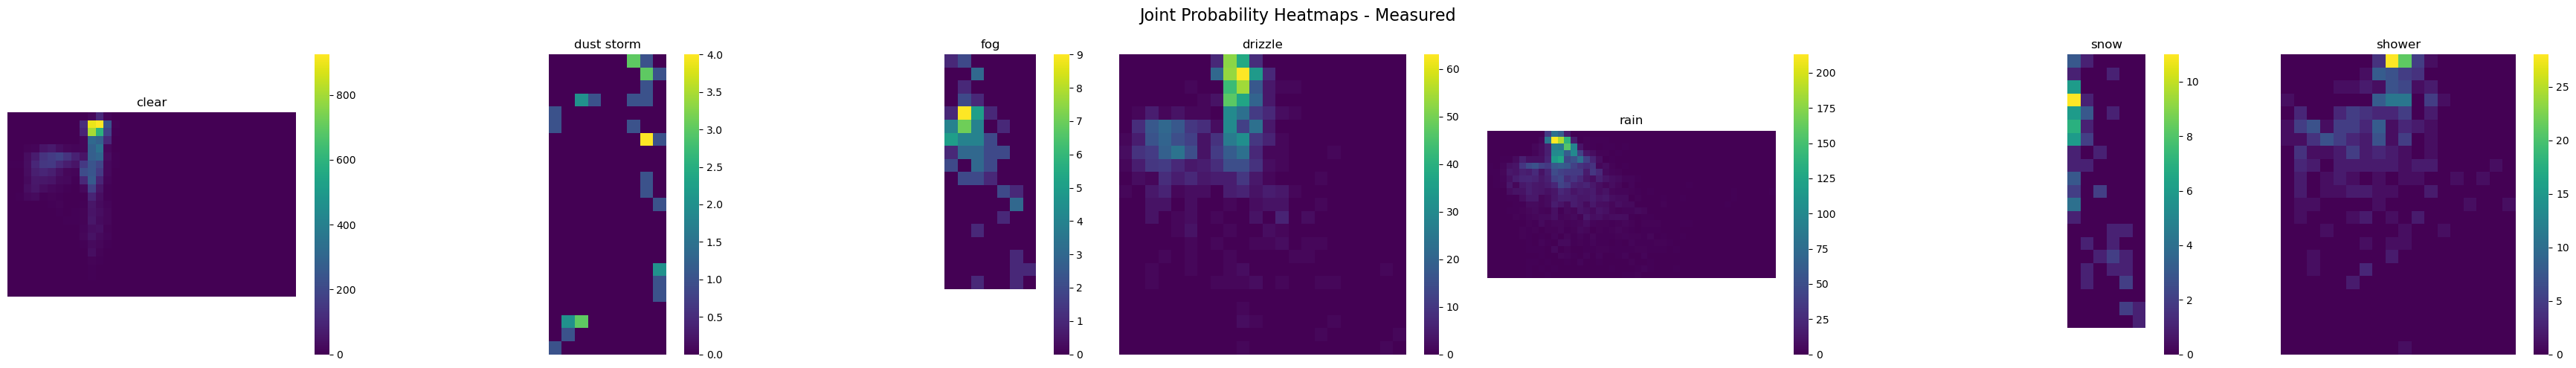

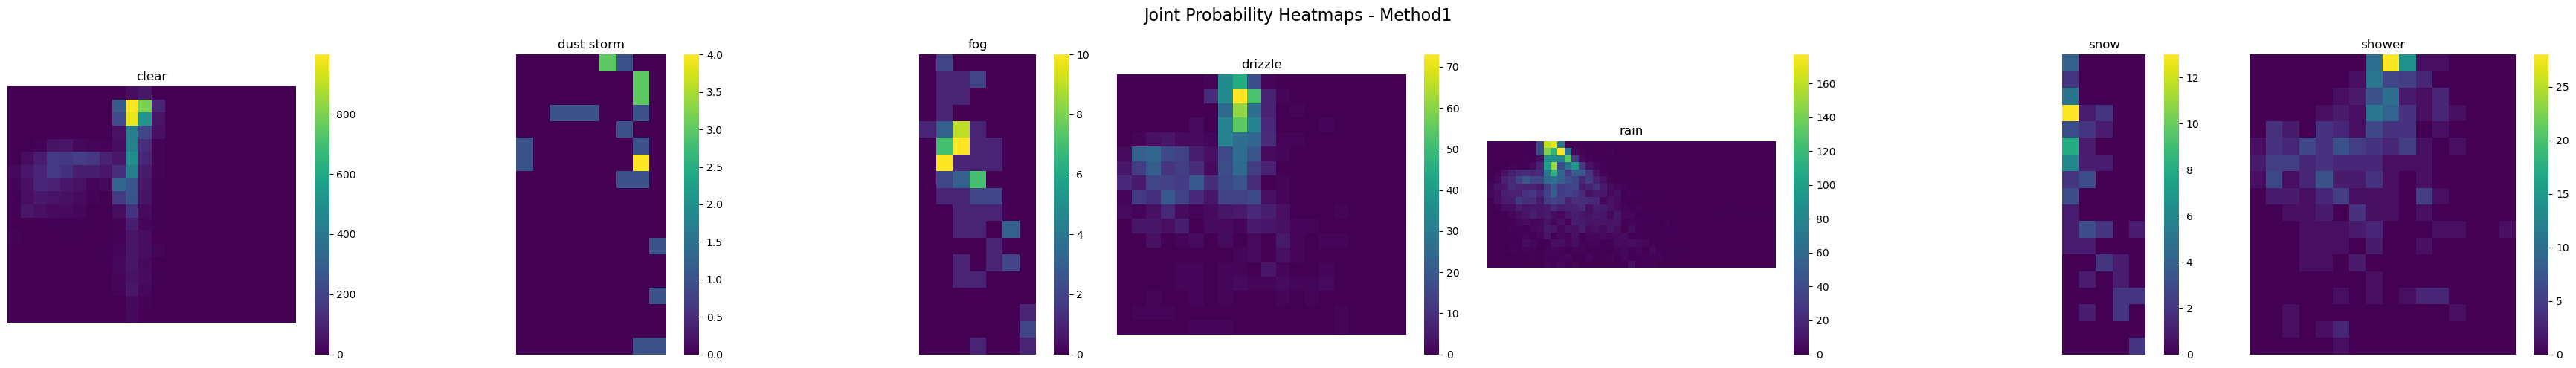

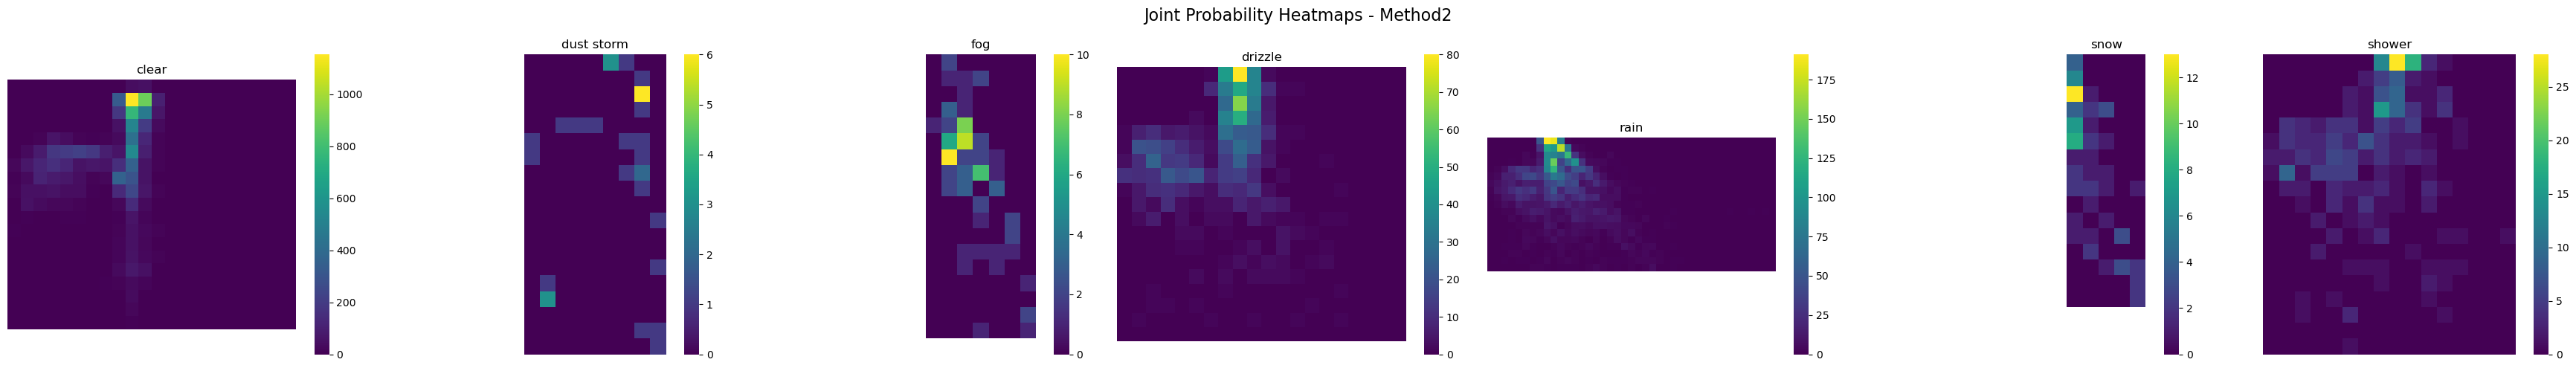

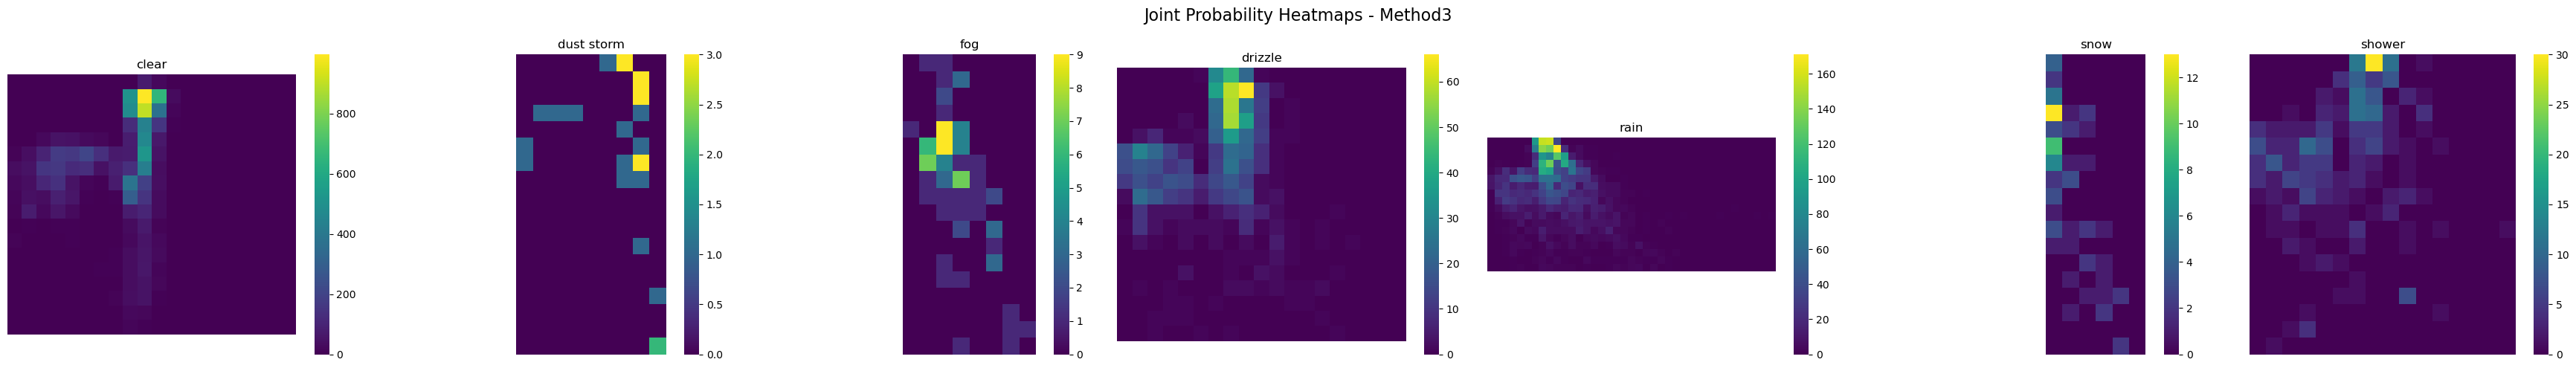

In [71]:
# Plot heatmaps for each method
methods = ["measured", "method1_Generic", "method2_Generic", "method3_Generic"]

for method in methods:
    num_synop_codes = len(heatmaps[method])
    fig, axes = plt.subplots(1, num_synop_codes, figsize=(5 * num_synop_codes, 5), sharey=True)
    
    if num_synop_codes == 1:
        axes = [axes]  # Ensure iterable for a single subplot
    
    for ax, (code, heatmap) in zip(axes, heatmaps[method].items()):
        sns.heatmap(heatmap, cmap="viridis", cbar=True, square=True, ax=ax)
        ax.set_title(f"{synop_codes[code]}")
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(f"Joint Probability Heatmaps - {method.replace('_Generic', '').capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.show()

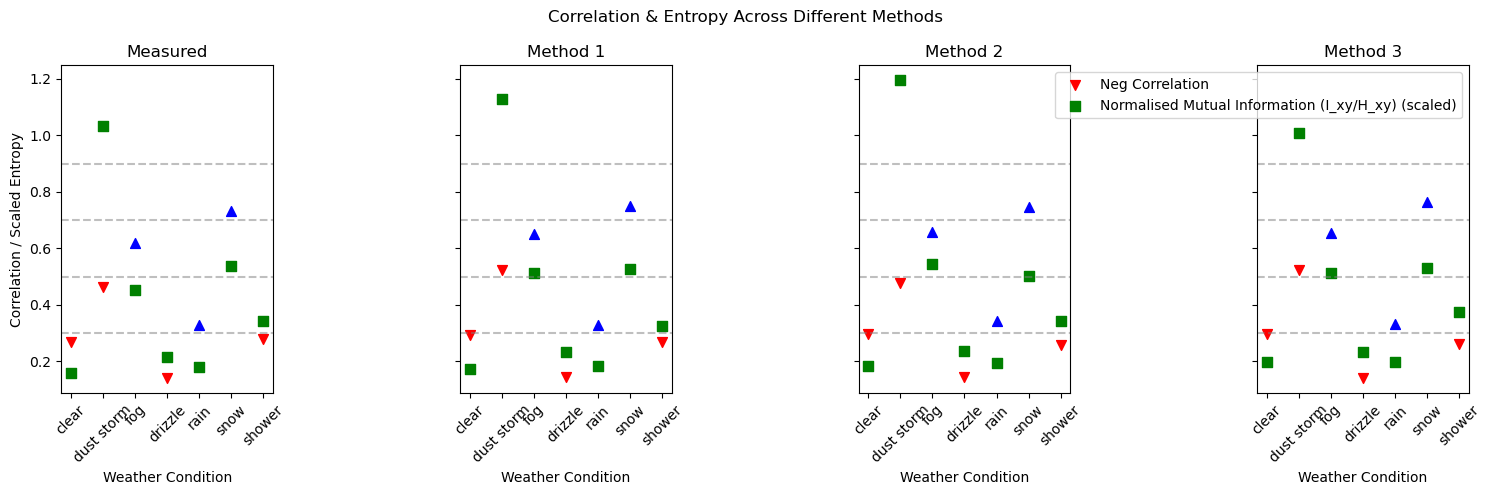

In [76]:
# Identify the index of the highest correlation in "measured"
high_corr_index = max(correlation_results["measured"], key=correlation_results["measured"].get)
high_corr_point = correlation_results["measured"][high_corr_index]
high_norm_mutual_inf_point = norm_mutual_inf_results["measured"][high_corr_index]  # Use the same index for entropy

# Compute entropy scale based on the identified high correlation point
entropy_scale = high_corr_point / high_norm_mutual_inf_point if high_norm_mutual_inf_point != 0 else 1

# Methods for plotting
methods = ["measured", "method1_Generic", "method2_Generic", "method3_Generic"]
method_labels = ["Measured","Method 1" ,"Method 2", "Method 3"]

corr_thresholds = [0.3,0.5,0.7,0.9]

# Create figure with 3 subplots for each method
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

for idx, method in enumerate(methods):
    ax = axes[idx]
    
    # X positions for different weather conditions
    x_positions = np.arange(len(synop_codes))
    
    # Get correlation and entropy values for each weather condition
    corr_vals = [correlation_results[method].get(code, 0) for code in synop_codes.keys()]
    ent_vals = [norm_mutual_inf_results[method].get(code, 0) * entropy_scale for code in synop_codes.keys()]
    
    # Scatter plot correlation with arrows
    for i, corr in enumerate(corr_vals):
        if corr >= 0:
            ax.scatter(x_positions[i], corr, color="blue", marker="^", s=50, label="Pos Correlation" if i == 0 else "")
        else:
            ax.scatter(x_positions[i], abs(corr), color="red", marker="v", s=50, label="Neg Correlation" if i == 0 else "")
    
    # Scatter plot entropy with red squares
    for i, ent in enumerate(ent_vals):
        ax.scatter(x_positions[i], ent, color="green", marker="s", s=50, label="Normalised Mutual Information (I_xy/H_xy) (scaled)" if i == 0 else "")
    
    # Add dotted lines for correlation thresholds
    for th in corr_thresholds:
        ax.axhline(th, color='gray', linestyle='--', alpha=0.5)
    
    # Format axes
    ax.set_xticks(x_positions)
    ax.set_xticklabels(synop_codes.values(), rotation=45)
    ax.set_title(f"{method_labels[idx]}")
    ax.set_xlabel("Weather Condition")
    
axes[0].set_ylabel("Correlation / Scaled Entropy")
fig.suptitle("Correlation & Entropy Across Different Methods")

plt.legend()
plt.tight_layout()
plt.show()